In [123]:
import pandas as pd
pd.set_option('max_colwidth', 10)
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline

In [124]:
# Importing training data
train = pd.read_csv('train.csv')

# Saving the 'Id' column
train_ID = train['Id']
#train.drop("Id", axis = 1, inplace = True)

# Extracting the target variable
train_SalePrice = train['SalePrice']

In [125]:
print("\nTrain is of shape: ", train.shape,"\n")


Train is of shape:  (1460, 81) 



Let's look at some sample training data:

In [126]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


At first glance it may appear that we are dealing with multiple columns with lots of missing data. While that might be true from some features, 'NA' is used to denote 'None' for many features. We have to sort this out.

In [127]:
for col in ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence','MiscFeature']:
    train[col] = train[col].fillna('None')

Let's look for missing data after sorting out the issue with 'NA':

In [128]:
# Missing data in train
train_na = train.isnull().sum()
train_na = train_na[train_na > 0]
train_na.sort_values(ascending=False)

LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
MasVnrType       8
Electrical       1
dtype: int64

Some observations:
 - We will have to take care of missing values in 'LotFrontage'. We can group by neighborhood, then replace missing values by the median 'LotFrontage' of the corresponding neighborhood.

 - Missing values in 'GarageYrBlt' could be due to no garage present. We replace missing values by those in 'YearBuilt'.
 - We will replace 'NA's in 'MasVnrType' with 'None's, which is already a valid option
 - 'NA's in 'MasVnrArea' will then be replaced with zero (no masonry veneer)
 - Only one value in 'Electrical' is missing. We can replace it witht the mode.

In [129]:
train['MasVnrType'] = train['MasVnrType'].fillna('None')

train['MasVnrArea'] = train['MasVnrArea'].fillna(0)

Electrical_mode = train['Electrical'].mode()[0]
print("Electrical_mode: ", Electrical_mode)
train['Electrical'] = train['Electrical'].fillna(Electrical_mode)

train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

train['GarageYrBlt'] = train['GarageYrBlt'].fillna(train['YearBuilt'])

Electrical_mode:  SBrkr


Let's make sure we have taken care of all missing values:

In [130]:
print(train['MSZoning'].mode()[0])
print(train['Functional'].mode()[0])      
print(train['BsmtHalfBath'].mode()[0])    
print(train['BsmtFullBath'].mode()[0])    
print(train['Utilities'].mode()[0])     
print(train['SaleType'].mode()[0])
print(train['GarageArea'].mode()[0])
print(train['GarageCars'].mode()[0])
print(train['KitchenQual'].mode()[0])
print(train['TotalBsmtSF'].mode()[0])
print(train['BsmtUnfSF'].mode()[0])
print(train['BsmtFinSF2'].mode()[0])
print(train['BsmtFinSF1'].mode()[0])
print(train['Exterior2nd'].mode()[0])
print(train['Exterior1st'].mode()[0])

RL
Typ
0
0
AllPub
WD
0
2
TA
0
0
0
0
VinylSd
VinylSd


In [131]:
# Missing data in train - There shouldn't be any at this point
train_na = train.isnull().sum()
train_na = train_na[train_na > 0]
train_na.sort_values(ascending=False)

Series([], dtype: int64)

The numbers in 'MSSubClass' have no significance (they're type identifiers), and should be treated as categories.

In [132]:
train['MSSubClass'] = pd.Categorical(train.MSSubClass)

The years in 'YrSold' and months in 'MoSold' should also be treated as categories.

In [133]:
train['YrSold'] = pd.Categorical(train.YrSold)
train['MoSold'] = pd.Categorical(train.MoSold)

Some features are similar and may be combined to form new features:

In [134]:
#  Computing total square-footage as a new feature
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']

#  Computing total 'porch' square-footage as a new feature
train['Total_porch_sf'] = (train['OpenPorchSF'] + train['3SsnPorch'] + train['EnclosedPorch'] 
                         + train['ScreenPorch'] + train['WoodDeckSF'])

#  Computing total bathrooms as a new feature
train['Total_Bathrooms'] = (train['FullBath'] + (0.5 * train['HalfBath']) +
                            train['BsmtFullBath'] + (0.5 * train['BsmtHalfBath']))

Let's extract numerical and categorical feature names:

In [135]:
feature_names = list(train.columns)
feature_names.remove('Id')

# Extracting categorical features
categorical_feats = list(train.select_dtypes(include=['category', 'object']))

# Extracting numerical features
numerical_feats = [feat for feat in feature_names if feat not in categorical_feats]

In [136]:
print("\nThere are ", len(categorical_feats), " categorical features.\n")
print("There are ", len(numerical_feats), " numerical   features.")


There are  46  categorical features.

There are  37  numerical   features.


In [137]:
print("\nThe numerical features are:\n\n", numerical_feats)  # Id is not really a feature
print("\n\nThe categorical features are:\n\n", categorical_feats)


The numerical features are:

 ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice', 'TotalSF', 'Total_porch_sf', 'Total_Bathrooms']


The categorical features are:

 ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Elect

Note that 'SalePrice', which is the target variable, is listed as a numerical feature. We will have to remove it before training the models. For now, we will leave it until we're done with filtering.

Let us look for obvious outliers by plotting the numerical features.

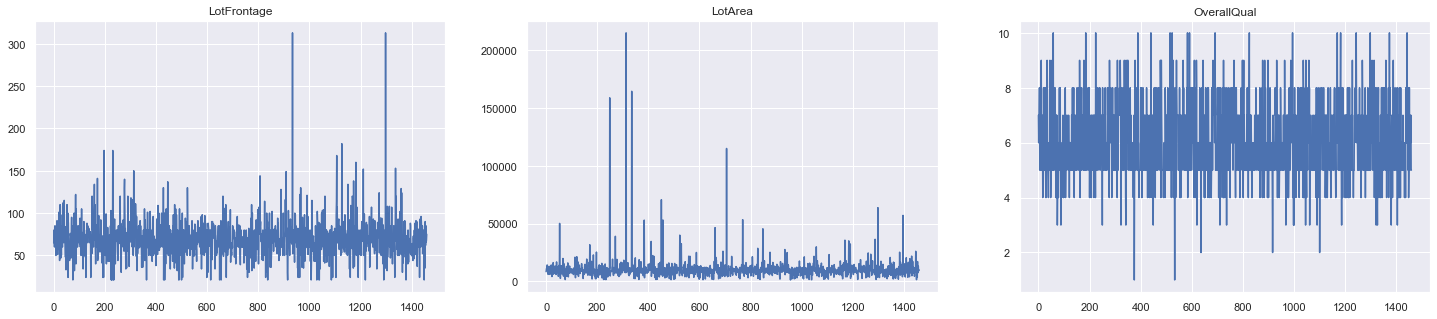

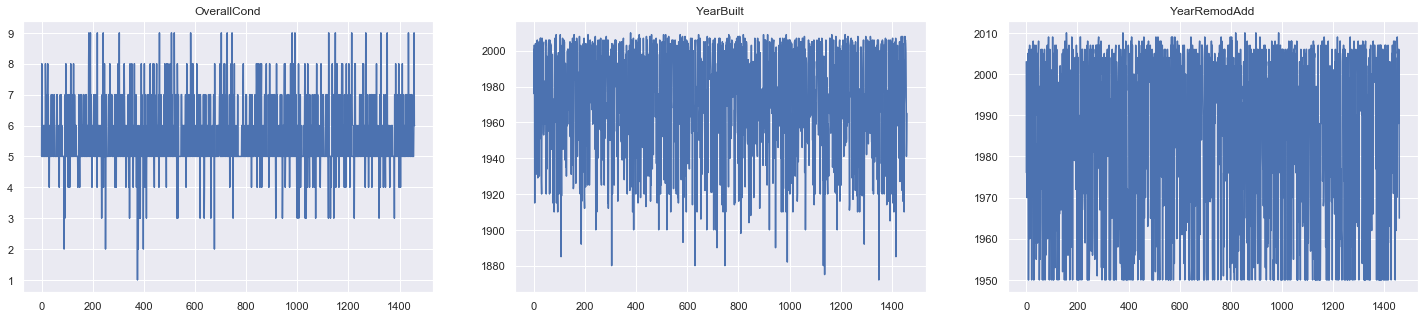

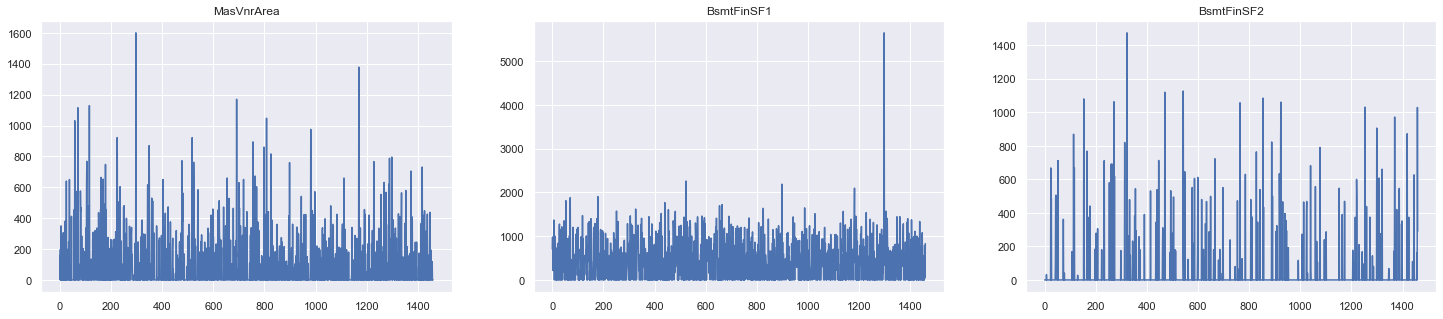

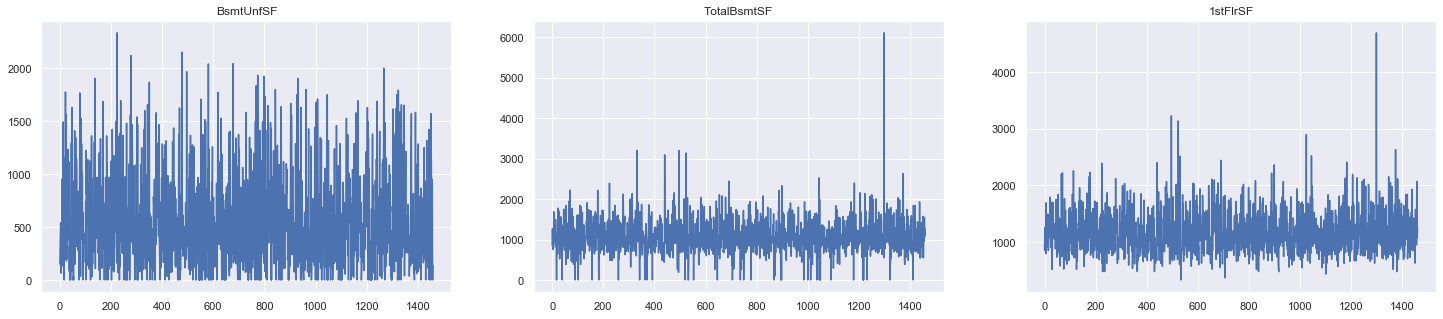

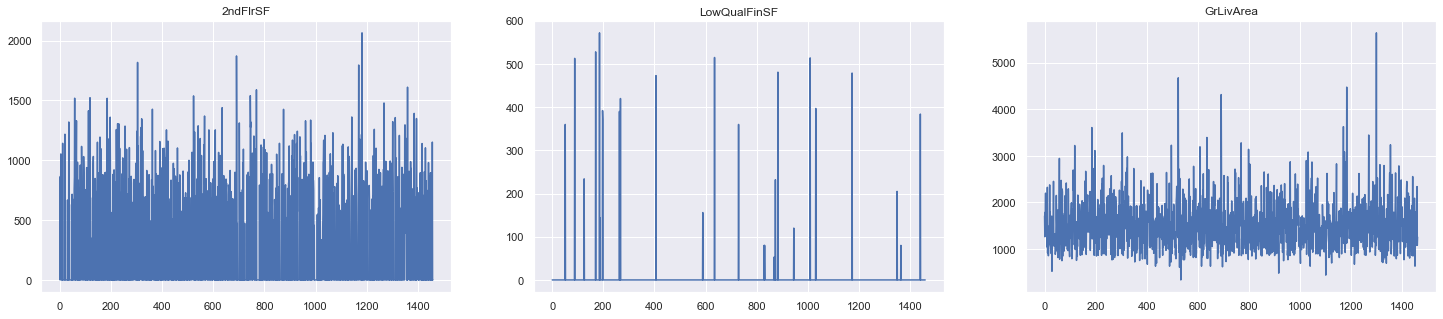

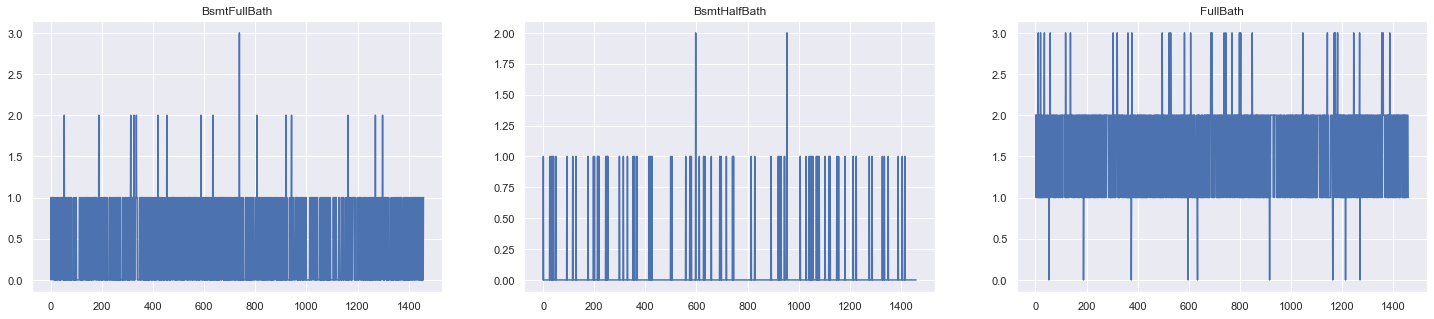

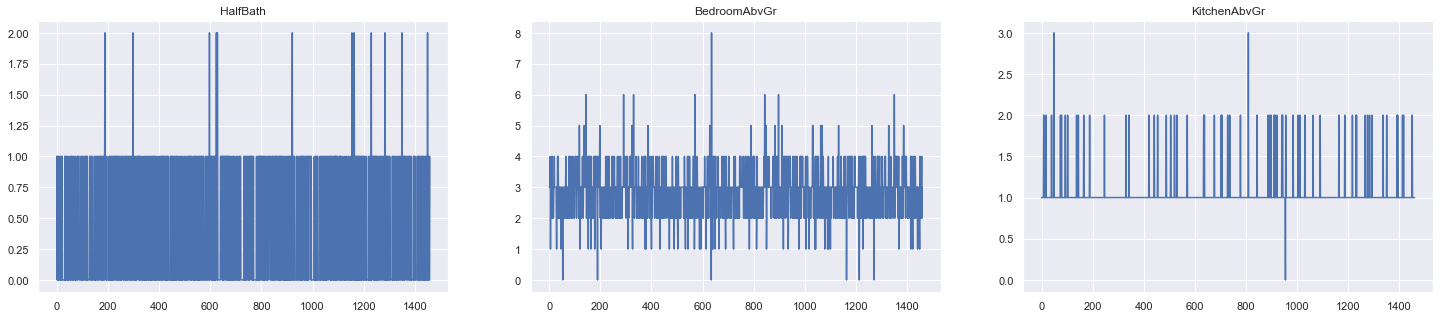

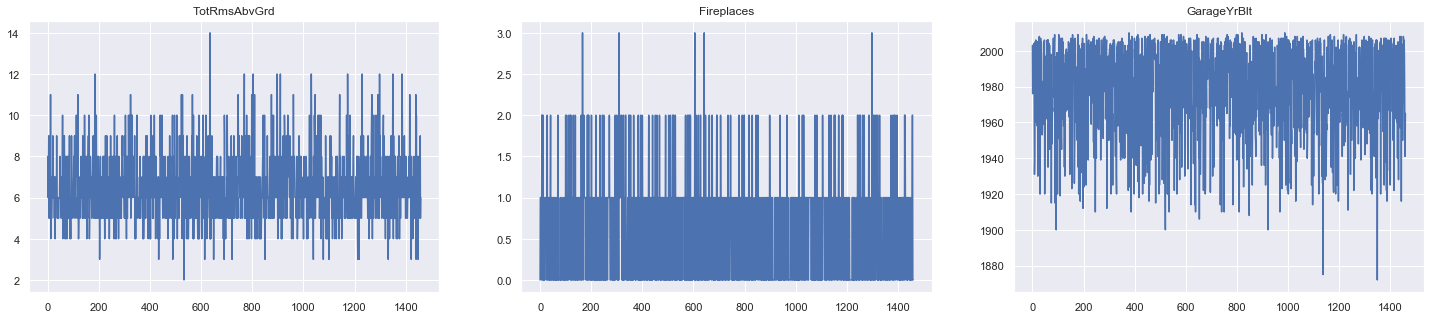

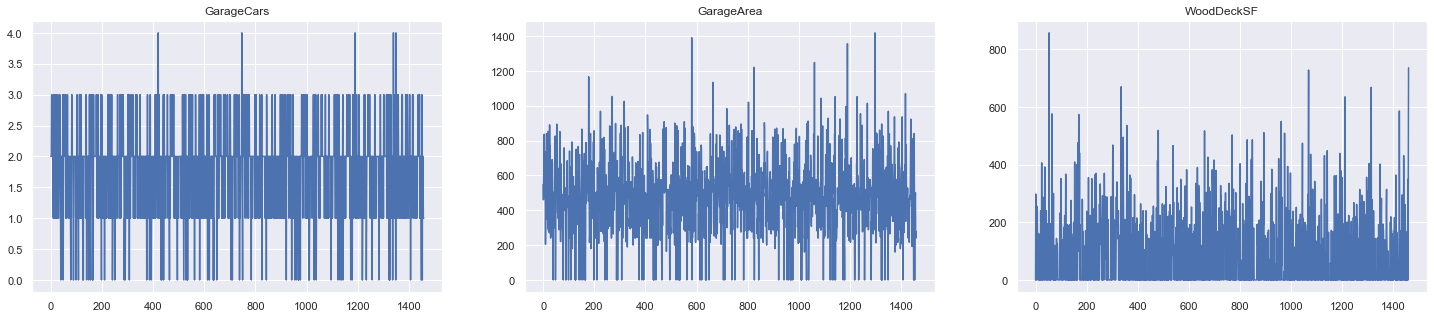

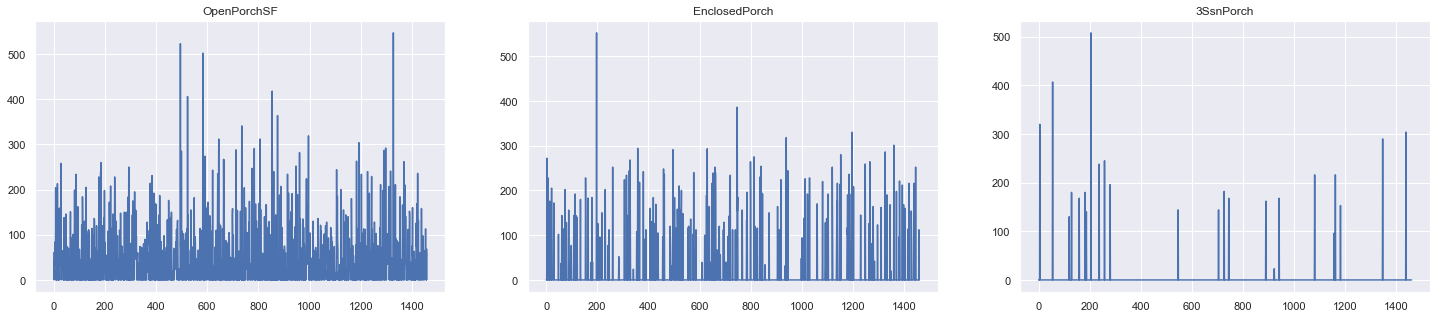

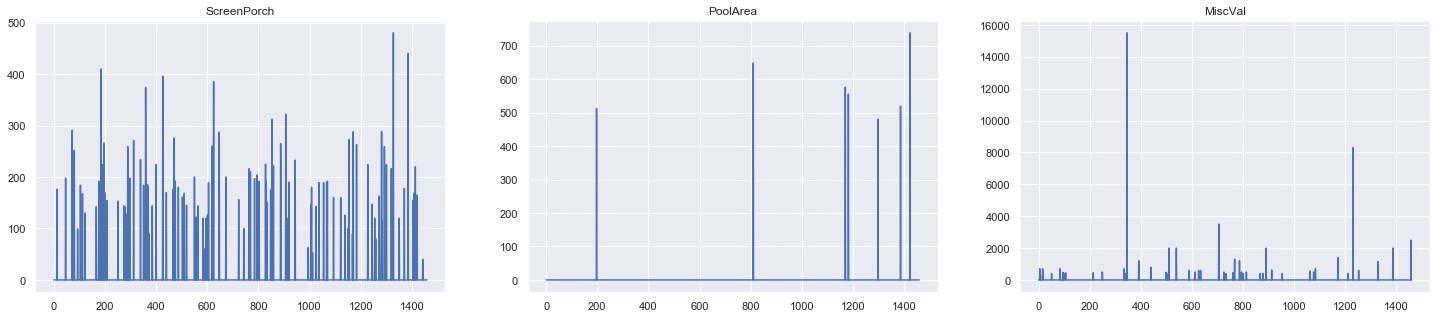

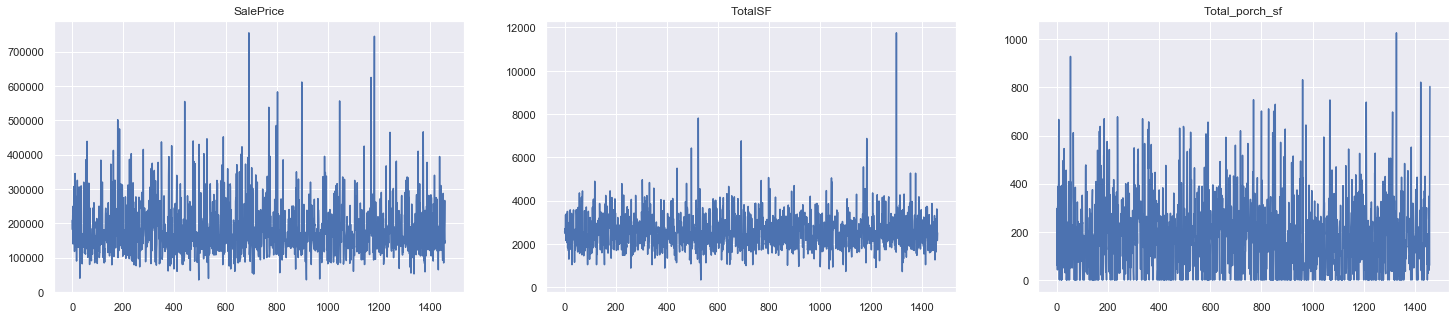

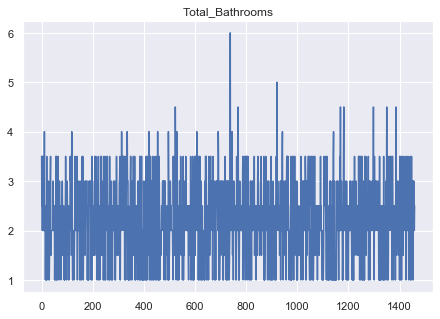

In [138]:
cnt = 0 
for feature in numerical_feats:
    plt.figure(cnt//3,figsize=(25,5))
    plt.subplot(1,3,np.mod(cnt,3) + 1)
    plt.plot(train[feature])
    plt.title(feature)
    cnt += 1

Looking at the plots above, we can set the following filters:

In [139]:
train = train[train.LotFrontage   < 200]
print("After filtering, train is of shape: ",train.shape)
train = train[train.LotArea       < 125000]
print("After filtering, train is of shape: ",train.shape)
train = train[train.MasVnrArea    < 1500]
print("After filtering, train is of shape: ",train.shape)
train = train[train.BsmtFinSF1    < 3000]
print("After filtering, train is of shape: ",train.shape)
train = train[train.BsmtFinSF2    < 1300]
print("After filtering, train is of shape: ",train.shape)
train = train[train.TotalBsmtSF   < 4000]
print("After filtering, train is of shape: ",train.shape)
train = train[train['1stFlrSF']   < 3500]
print("After filtering, train is of shape: ",train.shape)
train = train[train.GrLivArea     < 4500]
print("After filtering, train is of shape: ",train.shape)
train = train[train.GarageArea    < 1400]
print("After filtering, train is of shape: ",train.shape)
train = train[train.EnclosedPorch < 400]
print("After filtering, train is of shape: ",train.shape)
train = train[train.ScreenPorch   < 450]
print("After filtering, train is of shape: ",train.shape)
train = train[train.Total_Bathrooms   < 6]
print("After filtering, train is of shape: ",train.shape)
train = train[train.WoodDeckSF    < 700]
print("After filtering, train is of shape: ",train.shape)
train = train[train.OpenPorchSF   < 500]
print("After filtering, train is of shape: ",train.shape)

train.reset_index(drop=True, inplace=True)

After filtering, train is of shape:  (1458, 84)
After filtering, train is of shape:  (1455, 84)
After filtering, train is of shape:  (1454, 84)
After filtering, train is of shape:  (1454, 84)
After filtering, train is of shape:  (1453, 84)
After filtering, train is of shape:  (1453, 84)
After filtering, train is of shape:  (1453, 84)
After filtering, train is of shape:  (1452, 84)
After filtering, train is of shape:  (1452, 84)
After filtering, train is of shape:  (1451, 84)
After filtering, train is of shape:  (1450, 84)
After filtering, train is of shape:  (1449, 84)
After filtering, train is of shape:  (1446, 84)
After filtering, train is of shape:  (1444, 84)


In [140]:
# Let's save the remining IDs after filtering, then drop them
train_ID_filterd = train['Id']
train = train.drop(['Id'], axis=1)
train.shape

(1444, 83)

In [141]:
# Engineering some features into Booleans
f = lambda x: 1 if x > 0 else 0

train['has_pool'] = train['PoolArea'].apply(f)
train['has_garage'] = train['GarageArea'].apply(f)
train['has_bsmt'] = train['TotalBsmtSF'].apply(f)
train['has_fireplace'] = train['Fireplaces'].apply(f)

Some observations from the plots above:
 - 3SsnPorch, PoolArea, LowQualFinSF have very few nonzero values

In [142]:
# Dropping some features:
train = train.drop(['3SsnPorch', 'PoolArea', 'LowQualFinSF'], axis=1)

Let's inspect the feature names and types after filtering:

In [143]:
feature_names = list(train.columns)  # Ignoring 'SalePrice' (target)

# Extracting categorical features
categorical_feats = list(train.select_dtypes(include=['category', 'object']))

# Extracting numerical features
numerical_feats = [feat for feat in feature_names if feat not in categorical_feats]

In [144]:
print("\nThere are ",len(categorical_feats), " numerical features: \n"); print(numerical_feats);
print("\nThere are ", len(numerical_feats), " categorical features: \n"); print(categorical_feats);


There are  46  numerical features: 

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MiscVal', 'SalePrice', 'TotalSF', 'Total_porch_sf', 'Total_Bathrooms', 'has_pool', 'has_garage', 'has_bsmt', 'has_fireplace']

There are  38  categorical features: 

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'Heati

Let us now focus on cutting down the number of features, as not all of them are important:

In [145]:
def small_columns(df, col):
    if df.loc[:,col].value_counts()[-1] < 0.01*df.shape[0]:
        return True
    else: return False

In [146]:
import functools
small = list(filter(functools.partial(small_columns, train), 
                    list(train.select_dtypes(include=['object', 'category']).columns)))

Next, we split the labeled dataset 'train' into training set (80%) and a test (validation) set (20%):

In [147]:
from sklearn.model_selection import train_test_split
filtered_data_with_ID = train
filtered_data_with_ID['Id'] = train_ID
train, test = train_test_split(filtered_data_with_ID.drop(small, axis=1), train_size=0.8)

# Saving the test(validation) set to a json file
test.to_json("test_with_IDs.json")

y_train = train['SalePrice']
train_ID = train['Id']
train = train.drop(['Id'], axis=1)

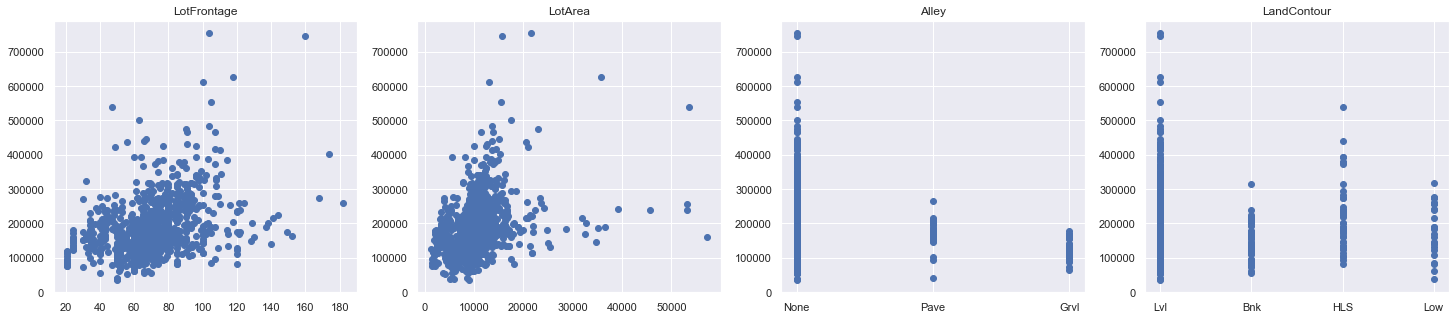

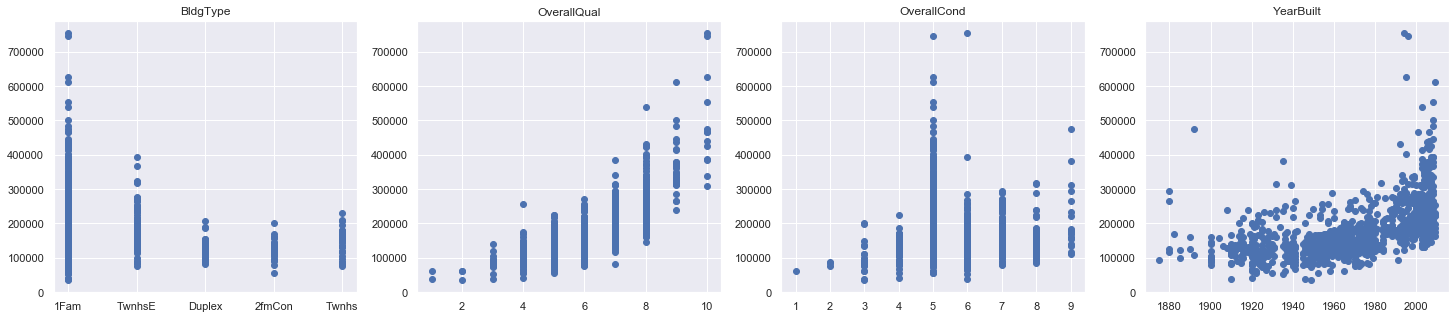

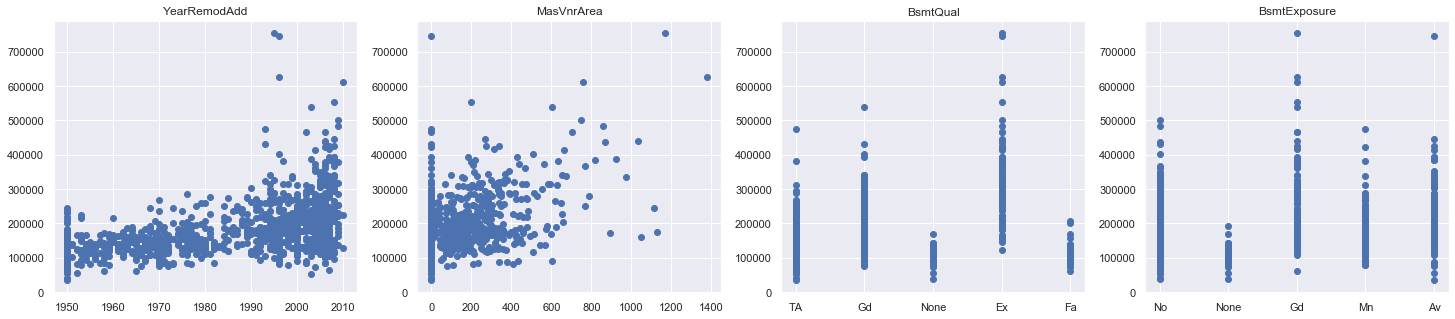

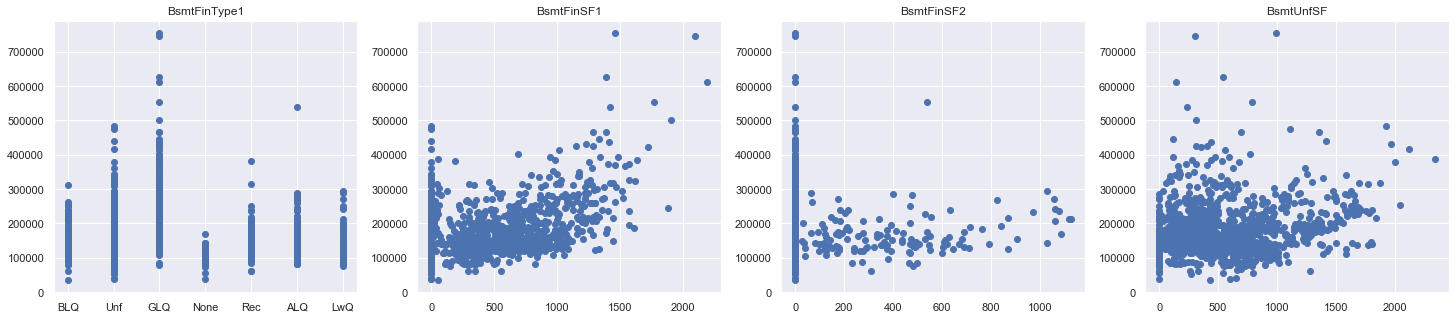

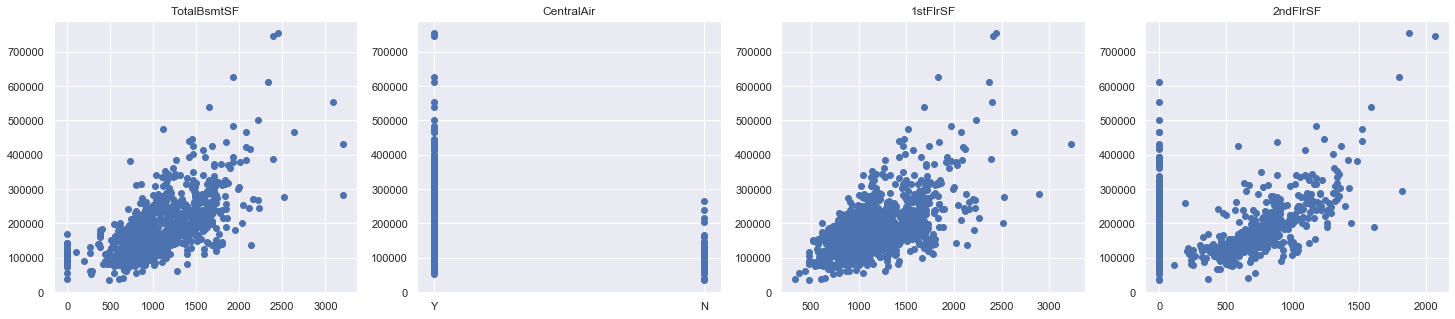

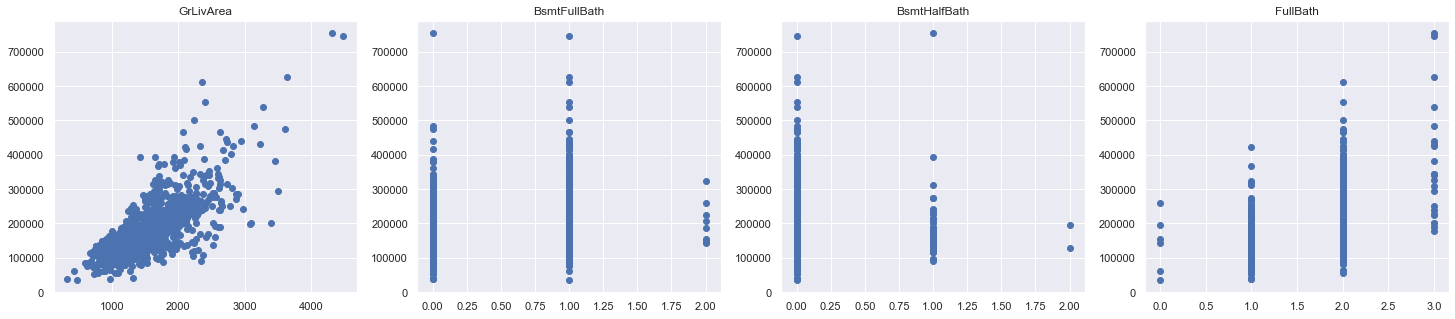

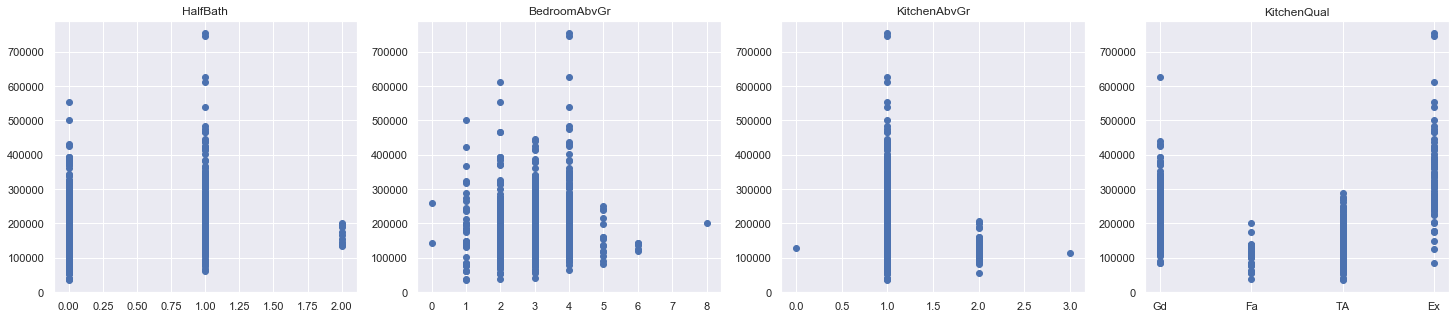

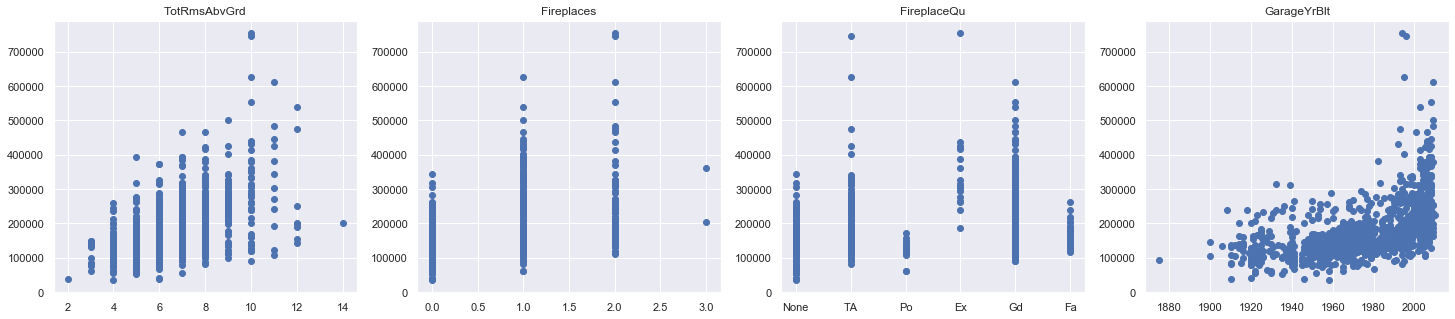

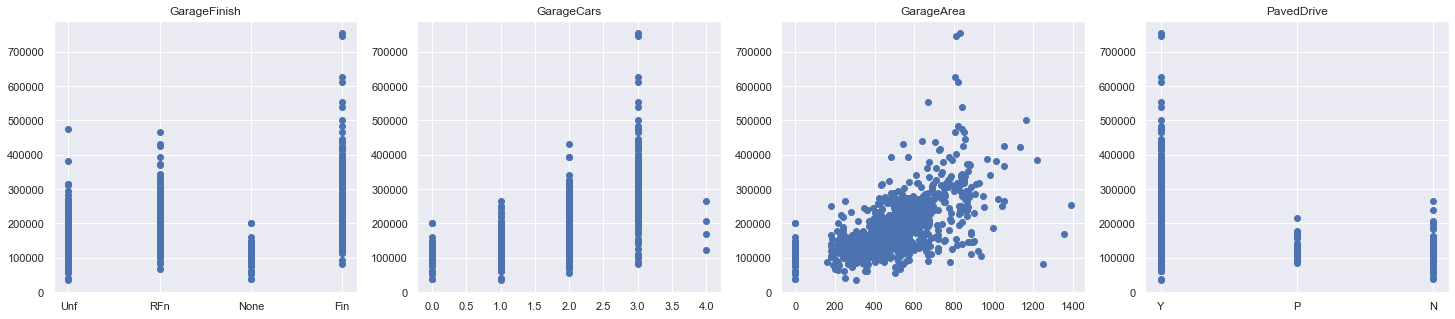

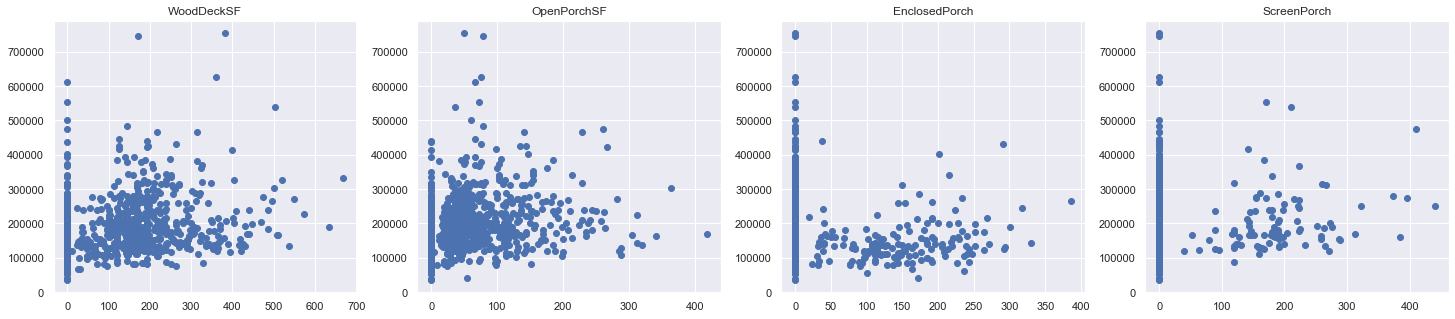

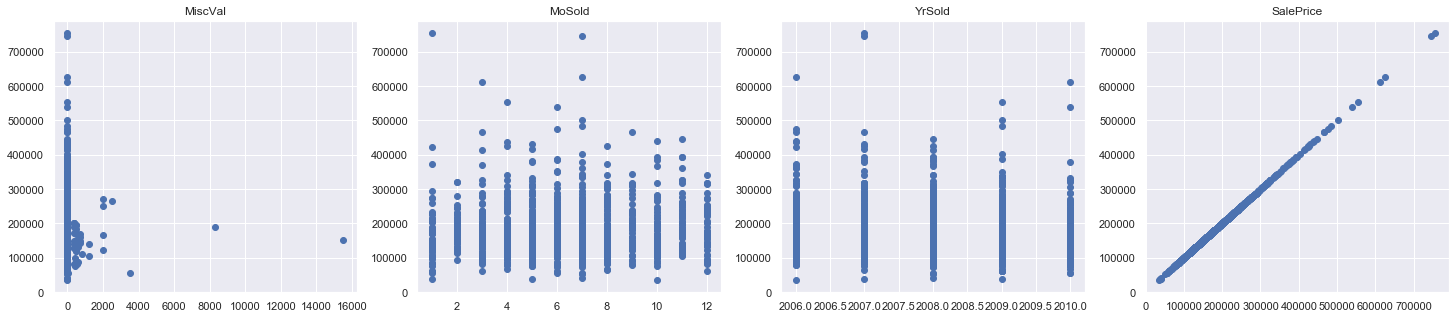

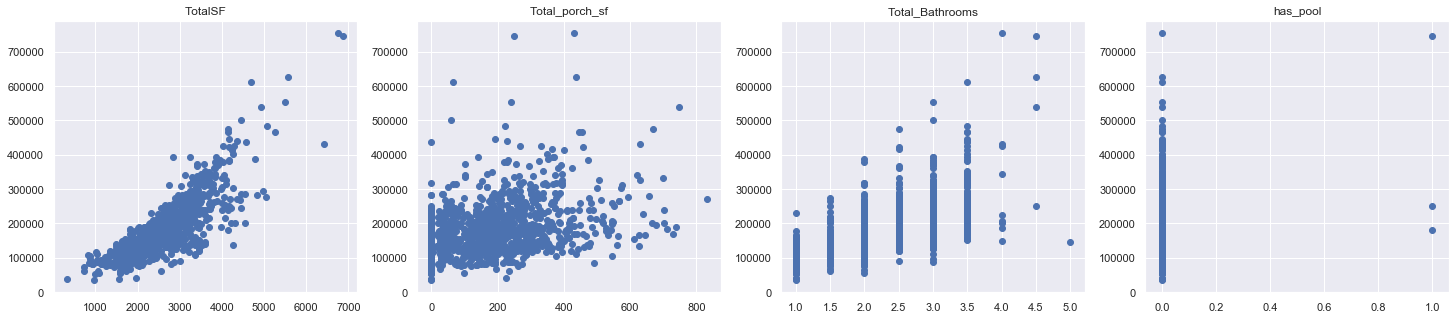

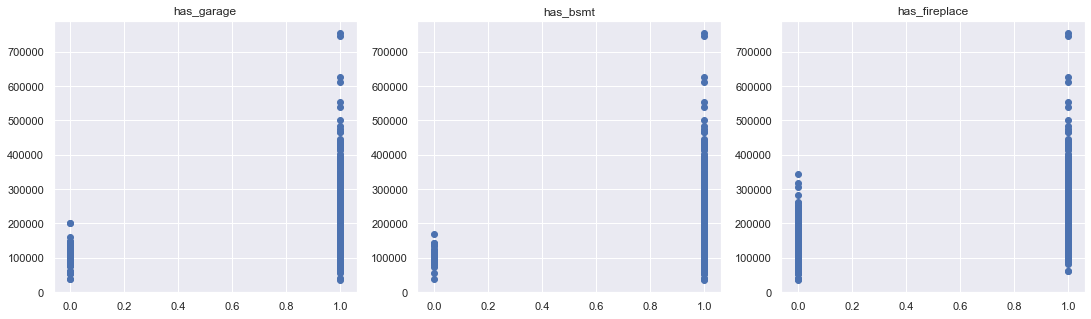

In [148]:
cnt = 0 
for feature in train.columns:
    plt.figure(cnt//4,figsize=(25,5))
    plt.subplot(1,4,np.mod(cnt,4)+1)
    plt.scatter(train[feature], y_train);
    plt.title(feature)
    cnt += 1

In [149]:
# Correlation matrix
corr_mat = train.corr()

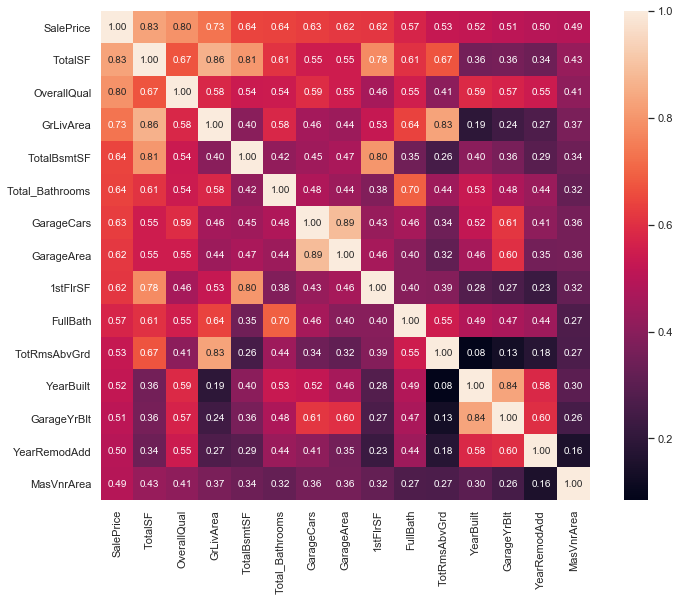

In [150]:
# Mapping largest 15 variables in correlation matrix
cols_corr = corr_mat.nlargest(15, 'SalePrice')['SalePrice'].index
corr_mat_sales = np.corrcoef(train[cols_corr].values.T)
#sns.set(font_scale=1.25)
plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat_sales, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols_corr.values, xticklabels=cols_corr.values)
plt.show()

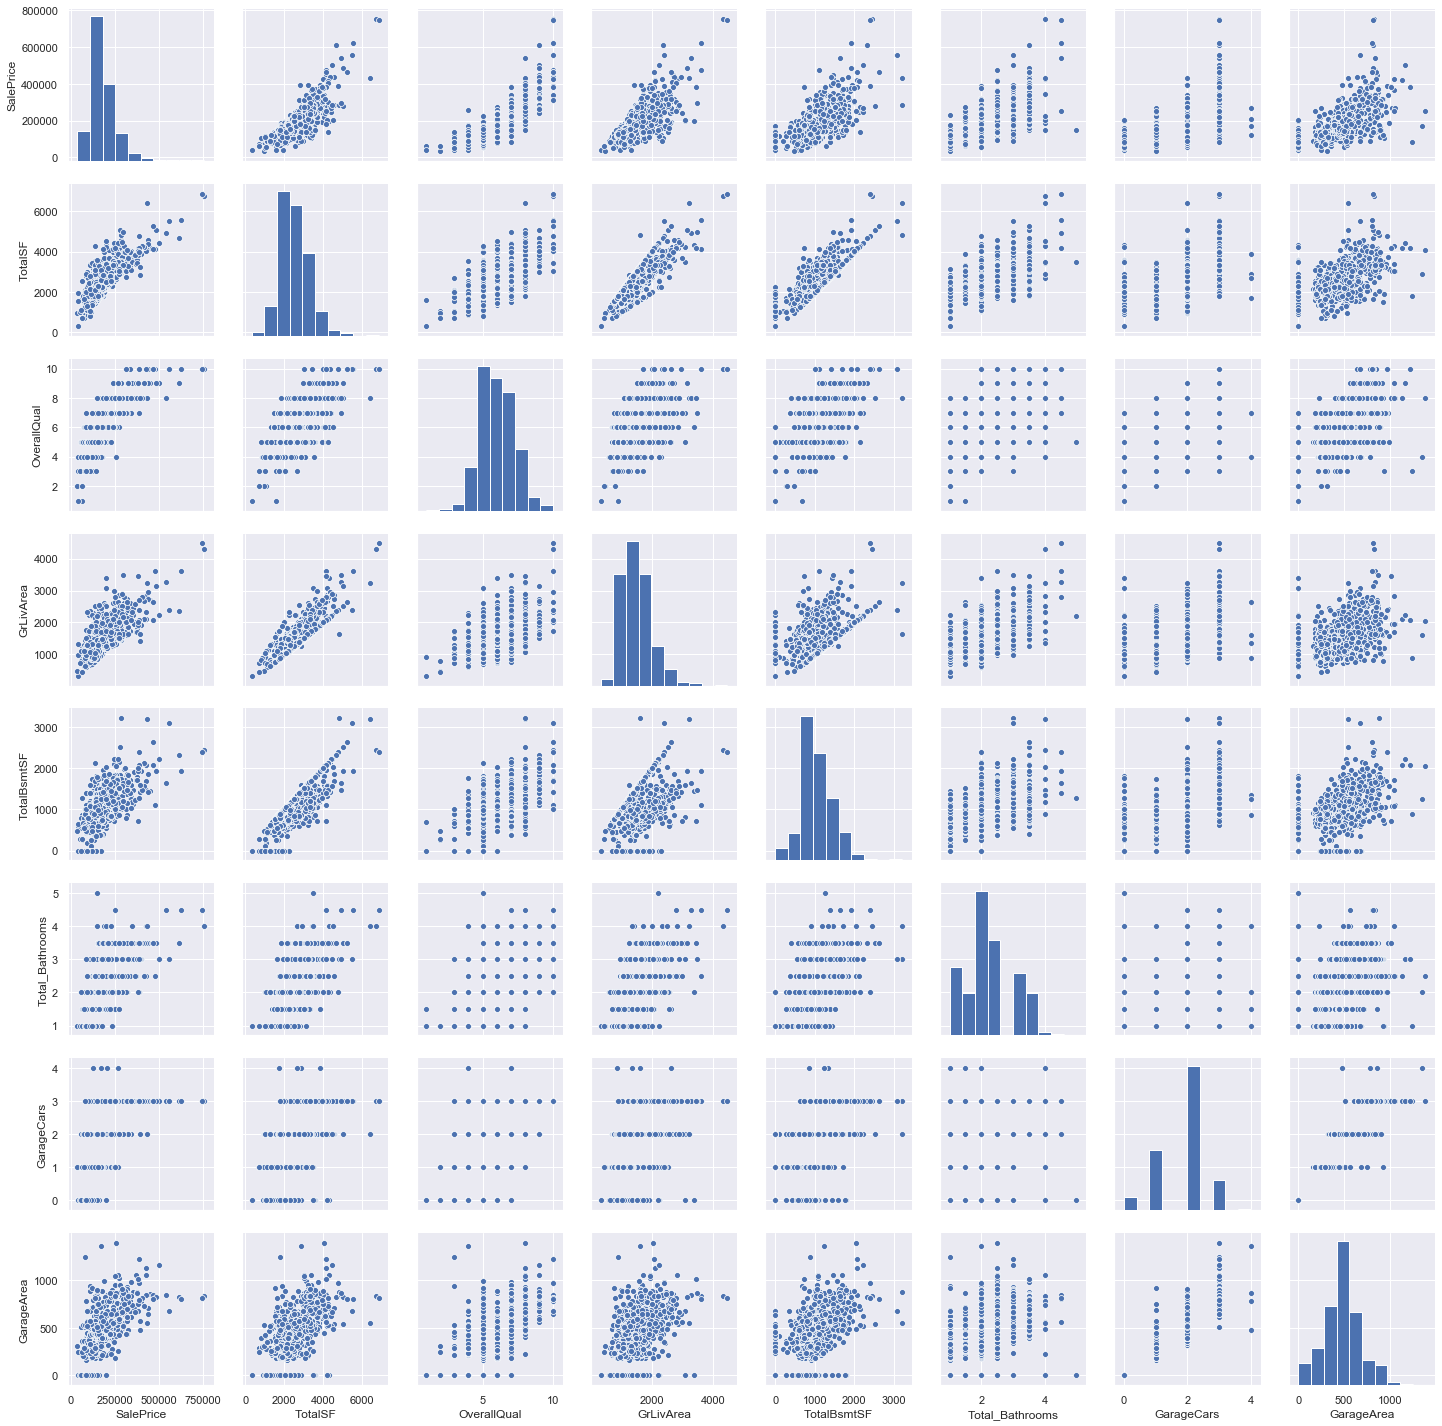

In [151]:
# Pair plots for 8 variables with largest correlation
sns.set()
sns.pairplot(train[cols_corr[0:8]], height = 2.5)
plt.show();

In [152]:
train_features = train.drop("SalePrice", axis = 1)
encoded_features = pd.get_dummies(train_features) # encoding categorical variables

In [153]:
print("\ntrain_features:   ", train_features.shape); 
print("\nencoded_features: ", encoded_features.shape);
print("\ny_train:          ", y_train.shape);


train_features:    (1155, 50)

encoded_features:  (1155, 102)

y_train:           (1155,)


In [154]:
from datetime import datetime
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error , make_scorer
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import LinearRegression
import xgboost

In [155]:
y_train = np.log1p(y_train)

In [156]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=123)

# Model scoring and validation function
def cv_RMSE(model, X=encoded_features):
    RMSE = np.sqrt(-cross_val_score(model, X, y_train, scoring="neg_mean_squared_error", cv=kfolds))
    return RMSE

In [157]:
e_alphas = [0.0001*i for i in range(1,8)]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]

# Kernel Ridge Regression
ridge_model = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))

# LASSO Regression
lasso_model = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, 
                    alphas=alphas2, random_state=123, cv=kfolds))

# XGBoost model
xgboost_model = make_pipeline(RobustScaler(), xgboost.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1))

In [158]:
# Store models, predictions, and scores
models = {'Ridge': ridge_model,
          'Lasso': lasso_model, 
          'XGBoost': xgboost_model}
predictions = {}
scores = {}

In [159]:
for name, model in models.items():
    
    model.fit(encoded_features, y_train)
    predictions[name] = model.predict(encoded_features)
    
    score = cv_RMSE(model, X=encoded_features)
    scores[name] = (score.mean(), score.std())

/Users/smerhi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/smerhi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/smerhi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/smerhi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/smerhi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base',

In [160]:
adjusted_predictions = {}
for name, model in models.items():    
    adjusted_predictions[name] = np.expm1(predictions[name])

In [161]:
print("Model Scores:")
print(pd.DataFrame(scores))
print("\nLogarithmic Predictions:")
print(pd.DataFrame(predictions).head(5))
print("\nAdjusted Predictions:")
print(pd.DataFrame(adjusted_predictions).head(5))

Model Scores:
   Ridge  Lasso  XGBoost
0  0.123  0.122    0.122
1  0.017  0.017    0.017

Logarithmic Predictions:
   Ridge  Lasso  XGBoost
0 11.727 11.734   11.739
1 12.015 11.993   11.990
2 11.389 11.376   11.309
3 12.318 12.327   12.348
4 11.755 11.769   11.765

Adjusted Predictions:
       Ridge      Lasso    XGBoost
0 123915.737 124683.138 125413.906
1 165269.329 161617.799 161197.031
2  88330.888  87164.934  81512.828
3 223638.680 225797.693 230601.266
4 127351.941 129159.813 128689.227


In [162]:
import pickle

In [164]:
# Fit the training data X, y
pickle.dump(xgboost_model, open("xgboost_model.pickle", "wb"))
pickle.dump(ridge_model, open("ridge_model.pickle", "wb"))
pickle.dump(lasso_model, open("lasso_model.pickle", "wb"))

In [163]:
pickle.dump(encoded_features.columns, open("train_encoded_columns.pickle", "wb"))

In [166]:
encoded_features.columns.values

array(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch',
       'MiscVal', 'TotalSF', 'Total_porch_sf', 'Total_Bathrooms',
       'has_pool', 'has_garage', 'has_bsmt', 'has_fireplace',
       'Alley_Grvl', 'Alley_None', 'Alley_Pave', 'LandContour_Bnk',
       'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl',
       'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex',
       'BldgType_Twnhs', 'BldgType_TwnhsE', 'BsmtQual_Ex', 'BsmtQual_Fa',
       'BsmtQual_Gd', 'BsmtQual_None', 'BsmtQual_TA', 'BsmtExposure_Av',
       'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No',
    